# Transformation Autoencoders

In this notebook we experiment with autoencoders on a (very simple) transformation learning setup.

## Data

For this first experiment, we will generate images of a rotating arrow, for which we will try to find some interesting representation.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import tensorflow as tf
import tfgraphviz as tfg
from tqdm import tqdm_notebook
import sys
sys.path.append("../src")
import simulation 

In [2]:
# We gather simulation
sim = simulation.RotatingArrowSimulation()

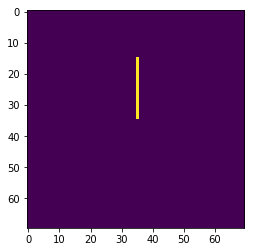

In [3]:
# We set sizes
im_size = 70
nb_samples = 300
# We instantiate the numpy array
X = sim.sample_trajectory([0.], [1.], nb_samples).reshape([-1,im_size**2])
# We check that our function works expectedly
plt.imshow(X[150].reshape(im_size,im_size))
plt.show()

### Experiment 

We tried different experiments, that approximately yielded the same results. We only publish this experiment that shows the type of results to expect with classic AE. 

Few remarks regarding the results of the experiments:
+ The algo yields the network to learn a 1-D representation
+ The out-of-training samples are in the convex hull of the training samples

In [41]:
# We instantiate the session
tf.reset_default_graph()
net_session = tf.InteractiveSession()

In [42]:
# We generate the architecture
with tf.variable_scope("Input"):
    net_input = tf.placeholder(tf.float32, shape=[None, im_size**2])
    noise_lvl = 0.5
    noise = tf.multinomial(tf.log([[noise_lvl, 1 - noise_lvl]]), tf.size(net_input))
    noise = tf.cast(tf.reshape(noise, shape=tf.shape(net_input)), dtype=tf.float32)
    net_noised_input = net_input*noise
# Encoder1
with tf.variable_scope("Encoder_1"):
    net_w1 = tf.Variable(tf.truncated_normal([im_size**2, 1200], stddev=0.1))
    net_b1 = tf.Variable(tf.constant(0.1, shape=[1200]))
    net_a1 = tf.matmul(net_noised_input, net_w1) + net_b1
    net_a1 = tf.nn.sigmoid(net_a1)
# Encoder2
with tf.variable_scope("Encoder_2"):
    net_w2 = tf.Variable(tf.truncated_normal([1200,256], stddev=0.1))
    net_b2 = tf.Variable(tf.constant(0.1, shape=[256]))
    net_a2 = tf.matmul(net_a1, net_w2) + net_b2
    net_a2 = tf.nn.sigmoid(net_a2)
# Encoder3
with tf.variable_scope("Encoder_3"):
    net_w3 = tf.Variable(tf.truncated_normal([256,2], stddev=0.1))
    net_b3 = tf.Variable(tf.constant(0.1, shape=[2]))
    net_a3 = tf.matmul(net_a2, net_w3) + net_b3
    net_a3 = tf.nn.sigmoid(net_a3)
# Decoder1
with tf.variable_scope("Decoder_1"):
    net_w4 = tf.Variable(tf.truncated_normal([2,256], stddev=0.1))
    net_b4 = tf.Variable(tf.constant(0.1, shape=[256]))
    net_a4 = tf.matmul(net_a3, net_w4) + net_b4
    net_a4 = tf.nn.sigmoid(net_a4)
# Decoder2
with tf.variable_scope("Decoder_2"):
    net_w5 = tf.Variable(tf.truncated_normal([256,1200], stddev=0.1))
    net_b5 = tf.Variable(tf.constant(0.1, shape=[1200]))
    net_bp5 = tf.Variable(tf.constant(1.), trainable=False)
    net_a5 = (1.-net_bp5)*net_a4 + net_bp5*net_a2
    net_a5 = tf.matmul(net_a5, net_w5) + net_b5
    net_a5 = tf.nn.sigmoid(net_a5)
# Decoder3
with tf.variable_scope("Decoder_3"):
    net_w6 = tf.Variable(tf.truncated_normal([1200, im_size**2], stddev=0.1))
    net_b6 = tf.Variable(tf.constant(0.1, shape=[im_size**2]))
    net_bp6 = tf.Variable(tf.constant(1.), trainable=False)
    net_a6 = (1.-net_bp6)*net_a5 + net_bp6*net_a1
    net_a6 = tf.matmul(net_a6, net_w6) + net_b6
    net_a6s = tf.nn.sigmoid(net_a6)
# We compute cost function
with tf.variable_scope("Loss"):
    net_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=net_a6, labels=net_input), reduction_indices=1)
    net_loss = tf.reduce_mean(net_loss)
    net_cost_function = net_loss
    net_optimizer = tf.train.AdamOptimizer(1e-3)
    net_descend = net_optimizer.minimize(net_cost_function)

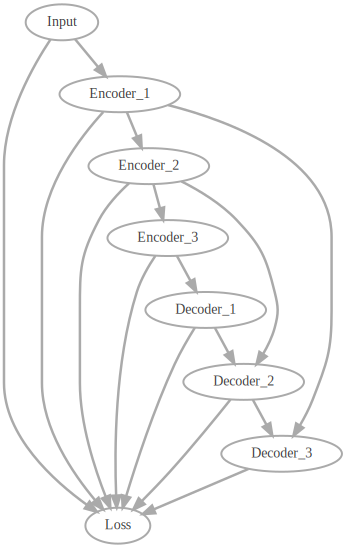

In [43]:
# We check the network
tfg.board(net_session.graph, depth=1)

In [44]:
# We initialize the variables
net_session.run(tf.global_variables_initializer())

In [56]:
# We train the network
batch_size = 1
nb_epochs = 20000
historical = np.zeros([nb_epochs])
# We loop through epochs
for i in tqdm_notebook(range(nb_epochs),desc="Epochs"):
    idx = np.random.permutation(range(X.shape[0]))[0:batch_size]
    net_descend.run(feed_dict={net_input:X[idx]})
    historical[i] = net_loss.eval(feed_dict={net_input:X[idx]})

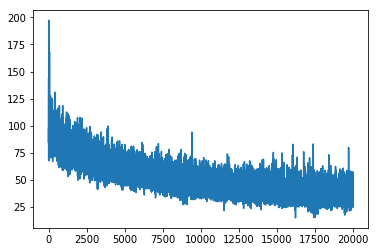

In [57]:
# We plot the learning curve
plt.plot(historical)
plt.show()

In [58]:
net_session.run(tf.assign(net_bp5, 0.))

0.0

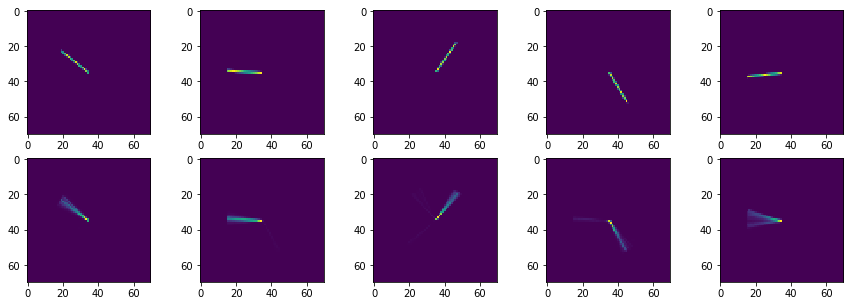

In [59]:
# We show reconstruction for some training samples
nb_draw = 5
idx = np.random.permutation(range(X.shape[0]))[0:nb_draw]
inpt = X[idx]
outpt = net_a6s.eval(feed_dict={net_input:inpt}) 
fig, ax = plt.subplots(ncols=nb_draw, nrows=2,figsize=(15,5))
for i in range(nb_draw):
    ax[0,i].imshow(inpt[i].reshape([im_size,im_size]))
    ax[1,i].imshow(outpt[i].reshape([im_size,im_size]))

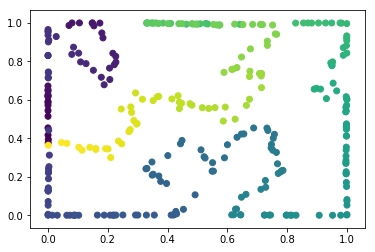

In [60]:
# We plot embedding variables evolution
nb_draw = 10
inpt = X
emb = net_a3.eval(feed_dict={net_input:inpt}) 
plt.scatter(emb[:,0], emb[:,1], c=range(X.shape[0]));

In [149]:
# We instantiate the numpy array
X_out = sim.sample_trajectory([0.5], [1.], nb_samples).reshape([-1,im_size**2])

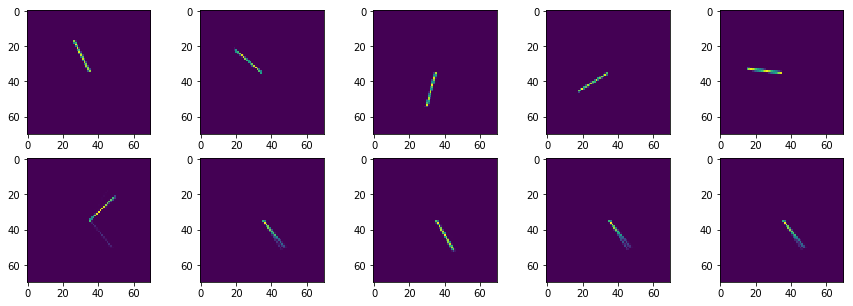

In [151]:
# We show reconstruction of out of training samples
nb_draw = 5
idx = np.random.permutation(range(X.shape[0]))[0:nb_draw]
inpt = X_out[idx]
outpt = net_a6s.eval(feed_dict={net_input:inpt}) 
fig, ax = plt.subplots(ncols=nb_draw, nrows=2,figsize=(15,5))
for i in range(nb_draw):
    ax[0,i].imshow(inpt[i].reshape([im_size, im_size]))
    ax[1,i].imshow(outpt[i].reshape([im_size, im_size]))

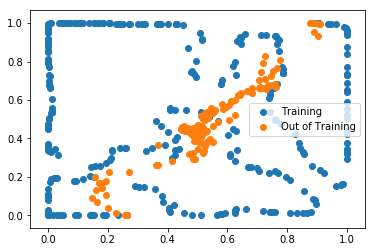

In [152]:
# We show training samples embeddings and out of samples embeddings
nb_draw = 10
inpt = X_out
emb2 = net_a3.eval(feed_dict={net_input:inpt}) 
plt.scatter(emb[:,0], emb[:,1], label="Training")
plt.scatter(emb2[:,0], emb2[:,1], label='Out of Training')
plt.legend()